In [18]:
import torch
import torchvision
from keras.utils import np_utils


In [19]:
import os
import numpy as np
import cv2
import pandas as pd

In [20]:

class Config():
    def __init__(self):
        pass
    
    num_classes=3
    labels_to_class = {0:'0',1:'1',2:'idle'}
    class_to_labels = {'0':0,'1':1,'idle':2}
    resize = 224	
    num_epochs =10
    batch_size =10

In [21]:
root_dir = r'H:\BML_data'
dest_dir = r'H:\BML_data_process'

In [22]:
if not os.path.exists(dest_dir):
    os.mkdir(dest_dir)

In [23]:
# To list what are the directories - train, test
data_dir_list = os.listdir(root_dir)

In [24]:
def vid_to_frame():
    for data_dir in data_dir_list:
        data_path = os.path.join(root_dir,data_dir)
        dest_data_path = os.path.join(dest_dir,data_dir)
        if not os.path.exists(dest_data_path):
            os.makedirs(dest_data_path)
            
        write_frames(data_path,dest_data_path)
    
    print(data_path)


In [29]:
def write_frames(vid_path,des_vid_path):
    # read the list of video from 'UCF-101/train/Archery' - [v_Archery_g01_c01.avi,v_Archery_g01_c01.avi, ......]
    vid_list = os.listdir(vid_path) 
    for vid in vid_list: # v_Archery_g01_c01.avi
        dest_folder_name = vid[:-4] # v_Archery_g01_c01
        dest_folder_path = os.path.join(des_vid_path,dest_folder_name) # 'activity_data/train/Archery/v_Archery_g01_c01'
        if not os.path.exists(dest_folder_path):
            os.mkdir(dest_folder_path)
            
        vid_path1 = os.path.join(vid_path,vid)  # 'UCF-101/train/Archery/v_Archery_g01_c01.avi'
        #print ('video path: ', vid_path1)
        cap = cv2.VideoCapture(vid_path1) # initialize a cap object for reading the video
        #print (cap)
        ret=True
        frame_num=0
        while ret:
            ret, img = cap.read()
            output_file_name = 'img_{:06d}'.format(frame_num) + '.png' # img_000001.png
            # output frame to write 'activity_data/train/Archery/v_Archery_g01_c01/img_000001.png'
            output_file_path = os.path.join(dest_folder_path, output_file_name)
            frame_num += 1
            #print("Frame no. ", frame_num)
            try:
                cv2.imshow('img',img)
                cv2.waitKey(5)
                cv2.imwrite(output_file_path, img) # writing frames to defined location
            except Exception as e:
                print(e)
            if ret==False:
                cv2.destroyAllWindows()
                cap.release()
if __name__ == '__main__':
   vid_to_frame()

In [12]:
train_data_path=dest_dir
data_files= r'H:\BML_data_process_csv'
if not os.path.exists(data_files):
    os.mkdir(data_files)

In [13]:
data_dir_list = os.listdir(train_data_path)
data_dir_list

['0', '1', 'idle']

In [28]:

num_classes = 3 
labels_name={'0':0,'1':1,'idle':2}

In [29]:
train_df_final=pd.DataFrame()
for data_dir in data_dir_list:
    label=labels_name[str(data_dir)]
    video_list = os.listdir(os.path.join(train_data_path,data_dir))
    train_df1=pd.DataFrame()
    for vids in video_list:
        train_df = pd.DataFrame(columns=['FileName', 'Label', 'ClassName'])
        img_list = os.listdir(os.path.join(train_data_path,data_dir,vids))
        for img in img_list:
            img_path = os.path.join(train_data_path,data_dir,vids,img)
            train_df = train_df.append({'FileName': img_path, 'Label': label,'ClassName':data_dir },ignore_index=True)
        train_df1=train_df1.append(train_df,ignore_index=True)
    train_df_final=train_df_final.append(train_df1,ignore_index=True)



    

In [30]:
file_name = 'train_vids.csv'
train_df_final.to_csv(f'{data_files}{file_name}')

In [31]:
import pandas as pd
import cv2
import numpy as np
from sklearn.utils import shuffle
import os
from collections import deque
import copy
import matplotlib
import matplotlib.pyplot as plt


%matplotlib inline  

In [32]:
def file_generator(data_path,data_files,temporal_stride=1,temporal_length=7):
    '''
    data_files - list of csv files to be read.
    '''
    for f in data_files: # read all the csv files (one csv file corresponds to one vdieo) in data_files one by one
        tmp_df = pd.read_csv(os.path.join(data_path,f))
        label_list = list(tmp_df['Label'])  # Load all the labels in the label_list
        total_images = len(label_list)
        if total_images>=temporal_length: # only if the number of frames in the video is greater tha temporal length, use that video
            num_samples = int((total_images-temporal_length)/temporal_stride)+1
            print(f'num of samples from vid seq-{f}: {num_samples}')
            img_list = list(tmp_df['FileName'])
        else: # if the number of frames are less than temporal length , discard it
            print(f'num of frames is less than temporal length; hence discarding this file-{f}')

            continue

        start_frame = 0
        samples = deque() # initliaze a queue to store the frames 
        samp_count=0 # a counter to count the number of smaple. one smaple has as many frames as defined by temporal length
        for img in img_list:
            samples.append(img)
            if len(samples)==temporal_length: #if the queue has as many frames as temporal length, return it as one sample
                samples_c=copy.deepcopy(samples) # copy the queue as in the next stage frames would be popped
                samp_count+=1
                for _ in range(temporal_stride):
                    samples.popleft()
                yield samples_c,label_list[0] # return a sample(consisting of as many frames as defined by temporal length) 
                                                # and its corsponding label

In [33]:
# Load the samples and their corresponding label for each video
def load_samples(data_cat='train',temporal_stride=1,temporal_length=7):
    data_path = os.path.join(data_files1,data_cat)
    data_files = os.listdir(data_path)
    print(data_files)
    # define a generator to read the samples
    file_gen = file_generator(data_path,data_files,temporal_stride,temporal_length)
    iterator = True
    data_list = []
    while iterator:
        try:
            x,y = next(file_gen)
            x=list(x)
            data_list.append([x,y])
        except Exception as e:
            print ('the exception: ',e)
            iterator = False
            print ('end of data generator')
    return data_list

In [ ]:
data_path=r'H:\BML_data_process_csv'
data_files1=r'H:\BML_data_process_csv'
train_data = load_samples(data_cat='train',temporal_stride=1,temporal_length=7)

In [35]:
print ('Total number of train samples:',len(train_data))

Total number of train samples: 145


In [37]:
def shuffle_data(samples):
    data=shuffle(samples,random_state=2)
    return data

In [38]:
def preprocess_image(img):
    img = cv2.resize(img,(224,224))
    img = img/255
    return img

In [39]:
def data_generator(data,batch_size=10,temporal_padding='same',shuffle=True):              
    """
    Yields the next training batch.
    data is an array [[img1_filename,img2_filename...,img16_filename],label1], [image2_filename,label2],...].
    """
    num_samples = len(data)
    if shuffle:
        data = shuffle_data(data)
    while True:   
        for offset in range(0, num_samples, batch_size):
            print ('startring index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for batch_sample in batch_samples: # Loop over every batch
                # Load image (X)
                x = batch_sample[0]
                y = batch_sample[1]
                temp_data_list = []
                for img in x:
                    try:
                        img = cv2.imread(img)
                        #apply any kind of preprocessing here
                        #img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                        img = preprocess_image(img)
                        temp_data_list.append(img)

                    except Exception as e:
                        print (e)
                        print ('error reading file: ',img)                      
                # Read label (y)
                #label = label_names[y]
                # Add example to arrays
                X_train.append(temp_data_list)
                y_train.append(y)
    
            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)
            # convert to one hot encoding for training keras model
            y_train = np_utils.to_categorical(y_train, 3)
            
            # yield the next training batch            
            yield X_train, y_train

In [40]:
train_generator = data_generator(train_data,batch_size=145,shuffle=True)

In [43]:
sig_tran = Config.labels_to_class[np.argmax(y_0)]


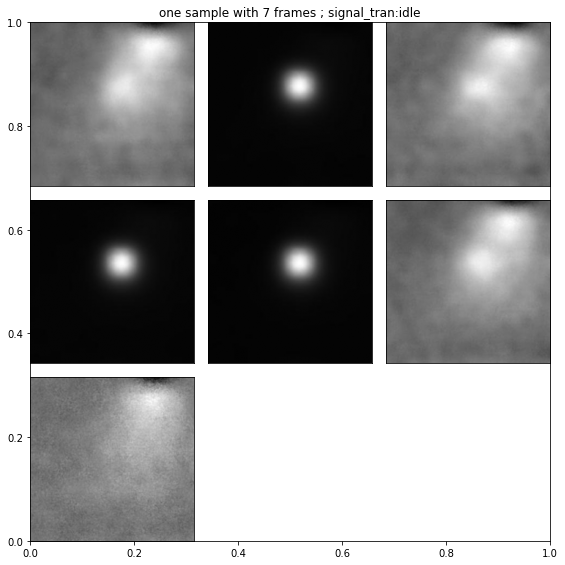

In [44]:
num_of_images=7
fig=plt.figure(figsize=(8,8))	
plt.title("one sample with {} frames ; signal_tran:{}".format(num_of_images,sig_tran))
subplot_num = int(np.ceil(np.sqrt(num_of_images)))
for i in range(int(num_of_images)):
    ax = fig.add_subplot(subplot_num, subplot_num, i+1)
    #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
    ax.imshow(x_0[i,:,:,::-1])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

In [45]:

import sklearn
from sklearn.manifold import TSNE
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe


In [46]:
X = np.vstack([x[i].flatten() for i in range(145)])
Y = np.array([np.argmax(y[i]) for i in range(145)])

In [47]:
digits_final = TSNE(perplexity=30).fit_transform(X)

In [66]:
def plot(x, colors):
  
    palette = np.array(sb.color_palette("hls", 3))  #Choosing color palette 

    # Create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    
    # Add the labels for each digit.
    txts = []
    for i in range(3):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([pe.Stroke(linewidth=5, foreground="w"), pe.Normal()])
        txts.append(txt)
    return f, ax, txts

In [2]:

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Input, LSTM
from tensorflow.keras.layers import MaxPooling2D as MaxPool2D
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import cv2
from glob import glob
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import math
import seaborn as sns
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model
sns.set()


Using TensorFlow backend.


In [6]:
def get_dropout(input_tensor,
                p=0.5,mc = False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

In [7]:
def build_frontend(num_classes,
                   dropout,input_shape = (224, 224, 3),mc = False):
    inp = Input(input_shape)
    x = Conv2D(32, (3, 3), input_shape = input_shape,activation='relu')(inp)
    x = Conv2D(32, (3, 3), activation = 'relu')(x)
    x = MaxPool2D(pool_size=(3, 3))(x)
    x = Flatten()(x)
    x = get_dropout(x, p=dropout, mc=mc)
    x = Dense(units = 500, activation = 'relu')(x)
    x = get_dropout(x, p = dropout, mc = mc)
    out = Dense(units=num_classes,
                activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adamax(),metrics=['accuracy'])
    return model



    

In [51]:
num_classes, class_labels, input_shape,X_train, X_test, y_train, y_test=get_frontend_data_setup(training_file_name =r'H:\BML_data_process_csvtrain_vids.csv')

100%|██████████| 1015/1015 [00:01<00:00, 584.42it/s]


In [54]:
def get_class_labels(training_file_name =r'H:\BML_data_process_csvtrain_vids.csv'):
    train = pd.read_csv(training_file_name)
    class_labels = train['ClassName'].unique().tolist()
    return class_labels

In [142]:
def standardize_matrix_size(data,num_classes):
    longest_size = 0
    for video in data:
        if video.shape[0] > longest_size:
            longest_size = video.shape[0]
    for video in range(len(data)):
        padded_matrix = np.zeros((longest_size, num_classes))
        padded_matrix[:data[video].shape[0],
                      :data[video].shape[1]] = data[video]
        data[video] = padded_matrix
        return data

In [ ]:
def get_mc_predictions(mc_model,test_set_images,n_iter = 500):
    mc_predictions = []
    for i in tqdm(range(n_iter)):
        y_p = mc_model.predict(test_set_images,
                               batch_size=50)
        mc_predictions.append(y_p)
        # make model predictions on the test set 500 times
    return mc_predictions

def get_flag1(p0, cutoff, stdev):
    flag = False
    if ((p0.mean(axis=0).max() < cutoff) or (len([i for i in p0.mean(axis=0)
                                                    if i > 0.25]) >= 2) or (p0.std(axis=0).max() > stdev)):
        flag = True
    return flag

In [141]:
def get_most_uncertain_images(test_set_images,mc_predictions, stdev):
    max_means = []
    max_vars = []
    class_preds = []
    flags = []
    for idx in range(test_set_images.shape[0]):
        px = np.array([p[idx] for
                       p in mc_predictions])
        class_preds.append(px.mean(axis=0).argmax())
        max_means.append(px.mean(axis=0).max())
        max_vars.append(px.std(axis=0)
                        [px.mean(axis=0).argmax()])
        flags.append(get_flag1(px, 0.6, stdev))
    test_uncertainties = pd.DataFrame({'max_means':max_means,'max_vars': max_vars,
                                       'class_pred': class_preds,
                                       'flagged': flags})
    top_by_prob = test_uncertainties.sort_values(by = ['max_means'])
    top_by_prob = top_by_prob.reset_index()
    top_by_var = test_uncertainties.sort_values(by = ['max_vars'],ascending = False)
    top_by_var = top_by_var.reset_index()
    return top_by_prob, top_by_var


In [205]:
vid_file= r'H:\BML_data'
files = glob('H:\BML_data_process\*')
files = glob(files[0])
videos = glob(f'{files[0]}/*')
# creating a dataframe having video names
train = pd.DataFrame()
train['video_name'] = videos
train = train[:-1]
for i in range(train.shape[0]):
    train['video_name'][i] = train['video_name'][i].split(' ')[0]
    video_names = train['video_name']
def get_back_input2(video_names,mc_model,
                    num_classes,n_iter = 500,
                    batch_size = 50,mc_preds = False):
    frames = []
    frame_labels = []
    frame_mc_preds = []
    belongs_to_video = []
    output = []
    output_labels = []
    the_images = []
    for i in tqdm(range(video_names.shape[0])):
        images=glob(video_names[i]+'\*')
        
        
        for j in range(len(images)):
            img = image.load_img(images[j],
                                 target_size=(224,224,3))
            img = image.img_to_array(img)
            img = img/255
            the_images.append(img)
            frames.append(img)
            belongs_to_video.append(i)
            frame_labels.append(os.path.split(files[0])[1])
            the_images = np.array(the_images)
            print(f"{str(i)}: {str(the_images.shape)}")
            video_frames_predictions = []
            for j in range(n_iter):
                y_p = mc_model.predict(the_images,
                                    batch_size=batch_size)
                video_frames_predictions.append(y_p)
            mean_video_frames_predictions = np.mean(video_frames_predictions,
                                                        axis = 0)
            output.append(mean_video_frames_predictions)
            output_labels.append(os.path.split(files[0])[1])
    frames = np.array(frames)
    frame_labels = pd.DataFrame(frame_labels,
                                    columns=['class'])
    frame_labels = pd.get_dummies(frame_labels)
    output = standardize_matrix_size(output,
                                         num_classes)
    if mc_preds:
        frame_mc_preds = get_mc_predictions(
            mc_model, frames, n_iter)
        return output, output_labels,frames, frame_labels,belongs_to_video, frame_mc_preds
    else:
        return output, output_labels, frames,frame_labels, belongs_to_video
    
    
 

In [194]:
def check_for_model_misunderstanding(mc_model,num_classes,class_labels,stdev,
                                     input_shape = (224, 224, 3),
                                     num_random_images = 100):
    posterior_counts = [0 for x in range(num_classes)]
    top_class_probs = np.empty(num_random_images)
    top_class_vars = np.empty(num_random_images)
    num_flags = 0
    for j in tqdm(range(num_random_images)):
        random_img = np.random.random(input_shape)
        random_predictions = []
        for i in range(100):
            y_p = mc_model.predict(np.array([random_img]))
            random_predictions.append(y_p)
        p0 = np.array([p[0] for p in random_predictions])
        index = p0.mean(axis=0).argmax()
        posterior_counts[index] = posterior_counts[index]+1
        top_class_probs[j] = p0.mean(axis=0)[index]
        top_class_vars[j] = p0.std(axis=0)[index]
        if get_flag1(p0, 0.6. stdev):
            num_flags = num_flags+1
    above_zero = []


In [143]:
def baseline_check_for_model_misunderstanding(model,num_classes,class_labels,
                                              thresh,
                                              input_shape = (224, 224, 3),
                                              num_random_images = 100):
    posterior_counts = [0 for x in range(num_classes)]
    num_flags = 0
    for j in tqdm(range(num_random_images)):
        random_img = np.random.random(input_shape)
        y_p = model.predict(np.array([random_img]))
        index = y_p.argmax()
        posterior_counts[index] = posterior_counts[index]+1
        if y_p.max() < thresh[int(index)]:
            num_flags = num_flags+1
    print()
    print('Percentage of randomly generated images flagged:')
    print(str(100* num_flags/num_random_images) + '%')
    print()
    above_zero = []
    for index in range(len(posterior_counts)):
        if posterior_counts[index] > 0:
            above_zero.append(index)
    



In [15]:
def build_backend(num_classes):
    backend = Sequential()
    backend.add(LSTM(50,
                     return_sequences = True,
                     input_shape = (None, num_classes)))
    backend.add(LSTM(50))
    backend.add(Dense(50,
                      activation = 'relu'))
    backend.add(Dense(num_classes))
    backend.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer='adam',
                    metrics=['categorical_accuracy', 'accuracy'])
    return backend


In [146]:
def plot_prediction(idx,
                    images,
                    labels,
                    mc_predictions,
                    class_labels,
                    num_classes):
    labels = labels.to_numpy()
    p0 = np.array([p[idx] for p in mc_predictions])
    p0_avg = p0.mean(axis=0)
    plt.figure(figsize = (12, 12))
    
    # second plot
    sns.barplot(orient = 'h')
    for dist in p0:
        sns.barplot(y =np.arange(num_classes), x = dist,
                    alpha = 0.1, orient = 'h')
    plt.xlim([0,1])
    #plt.title(’Posterior Samples’)
    # # third plot
    plt.ylabel('Class', fontsize = 22)
    plt.xlabel('Probability', fontsize = 22)
    plt.yticks(ticks = None, labels = None, color = 'w')
    plt.xticks(fontsize = 22)
    sns.barplot(y = np.arange(num_classes), x = p0_avg,
                linewidth=2.5, facecolor=(1, 1, 1, 0),
                edgecolor=".2", orient = 'h')


In [147]:
def plot_epoch_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [210]:
import matplotlib.pyplot as plt
import numpy as np
class_labels = get_class_labels()
dropout = 0.5
num_classes =1
input_shape = (224, 224, 3)
frontend = build_frontend(num_classes = num_classes,
                          dropout = dropout,
                          input_shape = input_shape,
                          mc = True)


In [211]:
backend = build_backend(num_classes)
non_mc_model = build_frontend(num_classes = num_classes,dropout = dropout,
                              input_shape = input_shape,
                              mc = False)

In [214]:
output, output_labels, frames, frame_labels,belongs_to_video,mc_preds = get_back_input2(video_names,
                                                                                        non_mc_model, num_classes,
                                                                                        n_iter = 100, batch_size = 50,
                                                                                        mc_preds = True)

  0%|          | 0/9 [00:00<?, ?it/s]

0: (1, 224, 224, 3)


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_11/conv2d_22/Relu
 (defined at c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4748)
]] [Op:__inference_predict_function_9878]

Errors may have originated from an input operation.
Input Source operations connected to node model_11/conv2d_22/Relu:
In[0] model_11/conv2d_22/BiasAdd (defined at c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\convolutional.py:271)

Operation defined at: (most recent call last)
>>>   File "c:\ProgramData\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
>>>     app.start()
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
>>>     self.io_loop.start()
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\asyncio\events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-212-9566bc453272>", line 1, in <module>
>>>     output, output_labels, frames, frame_labels,belongs_to_video,mc_preds = get_back_input2(video_names,
>>> 
>>>   File "<ipython-input-205-a6f936b81340>", line 39, in get_back_input2
>>>     y_p = mc_model.predict(the_images,
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1743, in predict
>>>     tmp_batch_outputs = self.predict_function(iterator)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1579, in predict_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1569, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1562, in run_step
>>>     outputs = model.predict_step(data)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1535, in predict_step
>>>     return self(x, training=False)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1044, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py", line 419, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py", line 555, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1044, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\convolutional.py", line 280, in call
>>>     return self.activation(outputs)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\activations.py", line 312, in relu
>>>     return backend.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
>>> 
>>>   File "c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py", line 4748, in relu
>>>     x = nn.relu(x)
>>> 

In [208]:
baseline_preds = non_mc_model.predict(frames,batch_size = 50)

NameError: name 'frames' is not defined